In [1]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL_ORIG = 'grid search'
ALGORITHM_DETAIL = 'grid search'
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [2]:
if False:
    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from keras.models import Sequential
    from keras.layers import Dense
    from scikeras.wrappers import KerasClassifier, KerasRegressor


    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(12, input_shape=(8,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


    # fix random seed for reproducibility
    seed = 7
    tf.random.set_seed(seed)
    # load dataset
    dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
    # split into input (X) and output (Y) variables
    X = dataset[:, 0:8]
    Y = dataset[:, 8]
    # create model
    model = KerasRegressor(model=create_model, verbose=0)
    # define the grid search parameters
    batch_size = [10, 20]  #, 40, 60, 80, 100]
    epochs = [10]  #, 50, 100]
    batch_size = [10, 20]
    epochs = [10, 20]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [3]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

from tensorflow import keras
from keras import layers

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


def create_model():
    # create model
    model = Sequential()
    # model.add(Dense(12, input_shape=(8,), activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
    return model


normalizer = tf.keras.layers.Normalization(axis=-1)

dnn_model = build_and_compile_model(normalizer)

model = KerasRegressor(model=create_model, verbose=1)

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    #('model', dnn_model)
    ('model', model)
])
model

2022-11-06 22:21:40.671139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


2022-11-06 22:21:48.732995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KerasRegressor(
	model=<function create_model at 0x7fdfba0441f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [6]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221106 import set_csv_directory, get_columns

    set_csv_directory('final_split')

debug_mode = False

In [7]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [8]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    features = df[df.columns[2:]].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index



In [9]:
df, retrieval_type = get_source_dataframe()
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [10]:
df

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
...,...,...,...,...,...,...,...,...,...
126179018,575000.0,2.0,1.0,0.682879,51.370651,-0.238346,0.129069,0.133926,FREEHOLD
126179672,600000.0,3.0,2.0,0.545665,51.357170,-0.074740,0.142550,0.029680,LEASEHOLD
126180107,419999.0,2.0,1.0,0.191407,51.531415,-0.052964,0.031695,0.051456,LEASEHOLD
126180704,475000.0,2.0,1.0,0.308609,51.543141,0.011498,0.043421,0.115918,LEASEHOLD


In [11]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [12]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000,46871.000000
mean,425069.390775,1.992469,1.182074,0.438847,51.497049,-0.113269,0.064317,0.124202
std,107227.324906,0.828837,0.409879,0.325942,0.077085,0.156489,0.042573,0.095607
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227169,51.438861,-0.210796,0.028876,0.043560
50%,425000.000000,2.000000,1.000000,0.367971,51.499977,-0.102230,0.058595,0.098984
75%,515000.000000,3.000000,1.000000,0.559620,51.556183,-0.010343,0.094362,0.192684
max,600000.000000,7.000000,5.000000,7.197700,51.683185,0.279726,0.201403,0.393895


In [13]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [14]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [15]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [16]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [17]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [18]:
from time import time

#pipe.fit(X_train, y_train)

if False:
    model = dnn_model
#model.fit(X_train, y_train)
if False:
    model.get_params()

In [19]:
X_train

array([[3.        , 3.        , 0.31661326, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.53093375, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.28550937, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [3.        , 1.        , 0.72181034, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.43589737, ..., 0.        , 1.        ,
        0.        ],
       [5.        , 3.        , 0.09716825, ..., 1.        , 0.        ,
        0.        ]])

In [20]:
if True:

    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from keras.models import Sequential
    from keras.layers import Dense
    from scikeras.wrappers import KerasClassifier


    # Function to create model, required for KerasClassifier
    def create_model():
        global ALGORITHM_DETAIL, ALGORITHM_DETAIL_ORIG

        # create model
        if False:
            model = Sequential()
            #model.add(Dense(12, input_shape=(8,), activation='relu'))
            #model.add(Dense(12, input_shape=(9,), activation='relu'))
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        elif False:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input_dense12, normaliser, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            #model.add(normalizer)
            model.add(Dense(1, activation='sigmoid'))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        elif True:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input64, norm, dense64^6, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(64, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(normalizer)
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        else:
            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = keras.Sequential([
                normalizer,
                layers.Dense(64, activation='relu'),
                layers.Dense(64, activation='relu'),
                #layers.Dense(132, activation='relu'),
                #layers.Dense(132, activation='relu'),
                layers.Dense(1)
            ])

            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL+= ' [normaliser, dense64, dense64]'

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model





# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters

if False:
    batch_size = [10, 100]  #, 40, 60, 80, 100]
    epochs = [100]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    #grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
else:
    options_block = {
    'epochs' : [100],
    #'optimizer' : ['rmsprop'],
    'batch_size' : [100],
    #'verbosity': 1
    }

     #['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].
    param_grid = {}
    for each in options_block:
        if type(options_block[each]) == list:
            #param_grid['model__' + each] = options_block[each]
            param_grid[each] = options_block[each]
        elif options_block[each] == None:
            #param_grid['model__' + each] = [options_block[each]]
            param_grid[each] = [options_block[each]]
        else:
            #param_grid['model__' + each] = [options_block[each]]
            param_grid[each] = [options_block[each]]
    #param_grid



grid = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=2, verbose=5)
#grid_result = grid.fit(X, Y)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2022-11-06 22:22:49.885273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 22:22:50.074762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 22:22:55.457151: I tensorflow/core/plat

Best: 0.480393 using {'epochs': 100, 'batch_size': 100}
0.480393 (0.017549) with: {'epochs': 100, 'batch_size': 100}


In [21]:
pipe = grid_result.best_estimator_
timings = []

if False:
    t0 = time()
    pipe.fit(X_train, y_train)
    timings.append(time() - t0)

    print(timings)
else:
    timings = [999]

average_time = sum(timings) / len(timings)
print(average_time)


999.0


In [22]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'epochs': 100, 'batch_size': 100}
0.48 (+/-0.035) for {'epochs': 100, 'batch_size': 100}
Best Index:  0
Best Score:  0.4803931287479381
Best Params:  {'epochs': 100, 'batch_size': 100}


In [23]:
pipe

KerasRegressor(
	model=<function create_model at 0x7fdf9e60baf0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=100
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [24]:
y_pred = pipe.predict(X_test)
#y_pred = pipe.evaluate(X_test, y_test, verbose=0)

In [25]:
pipe

KerasRegressor(
	model=<function create_model at 0x7fdf9e60baf0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=100
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [26]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy 0.49680316534001967
Mean Absolute Error Accuracy 59354.38214154203
Mean Squared Error Accuracy 5684315555.45259
Root Mean Squared Error 75394.40002714121


In [27]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [28]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754.0,400000.0,406821.37500,6821.37500,1.705344,1.676749
119328242.0,369950.0,345119.21875,24830.78125,6.711929,7.194842
125716790.0,350000.0,403465.53125,53465.53125,15.275866,13.251573
122440040.0,549000.0,469935.46875,79064.53125,14.401554,16.824551
120508103.0,495000.0,485069.84375,9930.15625,2.006092,2.047160
...,...,...,...,...,...
68620869.0,475000.0,553876.00000,78876.00000,16.605474,14.240733
85735665.0,575000.0,576014.43750,1014.43750,0.176424,0.176113
125706338.0,400000.0,436517.46875,36517.46875,9.129367,8.365637


In [29]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [30]:
score = pipe.score(X_test, y_test)
score

0.49680316534001967

In [31]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.49680316534001967

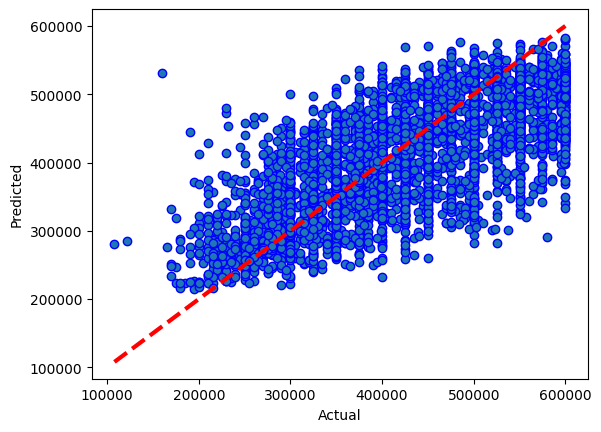

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [33]:
from datetime import datetime

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['_score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['best params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['best params'] = new_results['params']
        new_results['max score'] = new_results['_score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['_score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['_score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['best params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['best params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['_score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['best params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['_score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4, sort_keys=True))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'_score': 0.49680316534001967,
 'R square Accuracy': 0.49680316534001967,
 'Mean Absolute Error Accuracy': 59354.38214154203,
 'Mean Squared Error Accuracy': 5684315555.45259,
 'Root Mean Squared Error': 75394.40002714121,
 '_train time': 999.0,
 'random_state': 101,
 'date': '2022-11-06 22:30:24.182036',
 'params': {'epochs': 100, 'batch_size': 100},
 'first run': '2022-11-06 22:30:24.184480',
 'best params': {'epochs': 100, 'batch_size': 100},
 'max score': 0.49680316534001967,
 'suboptimal': 'pending'}

In [34]:
results
import pickle

# try:
#     model = pickle.load(open(f'model_{ALGORITHM}.pkl', 'rb'))
#     # raise ValueError
# except:
#     model = build_model(ALGORITHM, drop_nulls=~include_nulls)
#     with open(f'models/model_{ALGORITHM}.pkl', 'wb') as f:
#         pickle.dump(model, f)


with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}.pkl', 'wb') as f:
    pickle.dump(grid_result.best_estimator_, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmp6ithpw09/assets
